In [3]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [4]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp
import pandas as pd

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [6]:
ins_samples = {
    "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
    "PolII-IAA.hg19" : "PolII-IAA.hg19.mapq_30.1000.mcool",
    "PolII-NT.hg19" : "PolII-NT.hg19.mapq_30.1000.mcool",
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "CkoCT442_NT_pool.hg19" : "CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "CkoCT442-IAA-pool.mcool",
    # RAD21 degron for HCT from Rao et al 2017 ...
    "RAD21-IAA.hg19" : "RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",
    "RAD21-NT.hg19" : "RAD21-AID-NT.hg19.mapq_30.1000.mcool",

    "CkoC442-IAA48H-R1-T1.hg19" : "CkoC442-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoC442-NT-R1-T1.hg19" : "./wt_like_coolers_to_combine/CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19" : "CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-DDX55sg2-B-NT-R1-T1.hg19" : "CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "G1-NT.hg19" : "G1-NT.hg19.1kb.mcool",
    "G1-IAA.hg19" : "G1-IAA.hg19.1kb.mcool",
    
    # Mutants time !!!
    # Knock-outs - genes were deleted ...
    "mutControl-NT.hg19":"CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19":"CkoCT442-AAVS1-IAA-pool.mcool",
    "mutDDX55-NT.hg19":"DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19":"DDX55-clones-IAA.hg19.mapq_30.1000.mcool",
    "mutTAF5L-NT.hg19":"TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19":"TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",
    # Knock-downs - genes were silenced/deplted (siRNA) ...
    "siControl-NT.hg19":"siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19":"siCTRL-IAA.hg19.mapq_30.1000.mcool",
    "siDDX55-NT.hg19":"siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19":"siDDX55-IAA.hg19.mapq_30.1000.mcool",
    "siTAF5L-NT.hg19":"siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19":"siTAF5L-IAA.hg19.mapq_30.1000.mcool",
    
    # PlaB (splicing inhibition) two replicates pooled together - known to affect R-loops (mostly destabilize)
    "CtrlPlaB-NT.hg19" : "NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "IAA-PlaB-hg19-combined-90000000.mcool",
    
    ## Pool HAP1 WT, NO TIR1 and TIR1
    # this is a special subsampling case for the standard CTCF-degron(+aux)
    # but normalized, such that the number of reads, matches the NO-TIR1
    "Ctrl500M-noTIR1.hg19" : "CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-wtHAP1.hg19" : "Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-CT442-NT.hg19" : "CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "CkoCT442-IAA-pool-500000000.mcool",
}


In [7]:
all_genes = pd.read_table(
    "annotated_genes_for_pileups.bed",
    header=None,
    names=["chrom","start","end","strand","exp","size"]
)

### Let's exclude genes that have CTCF within 2kb of TSS ...

In [258]:
from copy import copy
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)



# .drop_duplicates(subset=["chrom_","tss_mflank_","tss_pflank_"])

In [259]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

5063 genes have CTCF@TSS,
    17231 genes do not -
    total # of genes 22294


#### same for TTS ...

In [263]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

2568 genes have CTCF@TTS,
    19726 genes do not -
    total # of genes 22294


#### combine TSS and TTS - without CTCF

In [264]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

15710 genes have no CTCF@TTS and no CTCF@TSS


### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [265]:
gdf = copy(all_genes_noctcf_atall)

#### Classify genes into discrete categories by gene-size and expression-level ...

In [266]:
exp_bin_edges = [0,.5,14,70,np.inf]
exp_labels = ("no","low","med","high")
sizes_bin_edges = [0,10_000,80_000,np.inf]
sizes_labels = ("short","medium","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,14361,29370,-,32,15009,med,medium
1,chr1,69090,70008,+,0,918,no,short
2,chr1,134772,140566,-,0,5794,no,short
3,chr1,562759,564389,-,0,1630,no,short
4,chr1,752750,755214,+,0,2464,no,short


gsize,short,medium,long
gexp,,,
no,4623,3133,1121
low,682,1511,790
med,400,1506,620
high,355,858,111


### Let's use coolpup as Python API ...

In [267]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [268]:
# import standard python libraries
import seaborn as sns
# import libraries for biological data analysis
import coolpuppy as cp
import cooler
import bioframe
# import cooltools
# import cooltools.expected
# from cooltools.lib import plotting

In [269]:
def get_pup(sites, clr, resolution):
    """
    generate scaled local pile-up for a collection of sites for a given
    cooler (clr) at a given resolution - keeping the padding size equal
    to the interval itself.
    """
    _sites = sites[["chrom","start","end","strand"]].reset_index(drop=True)
    cc = cp.CoordCreator(
        _sites,
        resolution=resolution,
        basetype='bed',
        local=True,
        fraction_pad=1.
    )
    pu = cp.PileUpper(
        clr,
        cc,
        control = True,
        rescale = True,
        rescale_size = 199,
    )
    print(f"working on a group of {len(_sites)} size ...")
    pup = pu.pileupsByStrandWithControl(nproc=3)
    return pup


In [270]:
key_samples = ["Ctrl500M-CT442-NT.hg19", "Ctrl500M-CT442-IAA.hg19"]
pup_dict = {}
binsize = 10_000

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for sample in key_samples:
    print(f"working on {sample} ...")
    cname = ins_samples[sample]
    clr = cooler.Cooler(f"{cname}::/resolutions/{binsize}")
    pup_dict[sample] = gene_groups.apply( lambda sub_df: get_pup(sub_df, clr, binsize) )

working on Ctrl500M-CT442-NT.hg19 ...
working on a group of 4623 size ...
working on a group of 3133 size ...
working on a group of 1121 size ...
working on a group of 682 size ...
working on a group of 1511 size ...
working on a group of 790 size ...
working on a group of 400 size ...
working on a group of 1506 size ...
working on a group of 620 size ...
working on a group of 355 size ...
working on a group of 858 size ...
working on a group of 111 size ...
working on Ctrl500M-CT442-IAA.hg19 ...
working on a group of 4623 size ...
working on a group of 3133 size ...
working on a group of 1121 size ...
working on a group of 682 size ...
working on a group of 1511 size ...
working on a group of 790 size ...
working on a group of 400 size ...
working on a group of 1506 size ...
working on a group of 620 size ...
working on a group of 355 size ...
working on a group of 858 size ...
working on a group of 111 size ...


### plotting different pileups for different groups ...

In [278]:
from matplotlib import colors

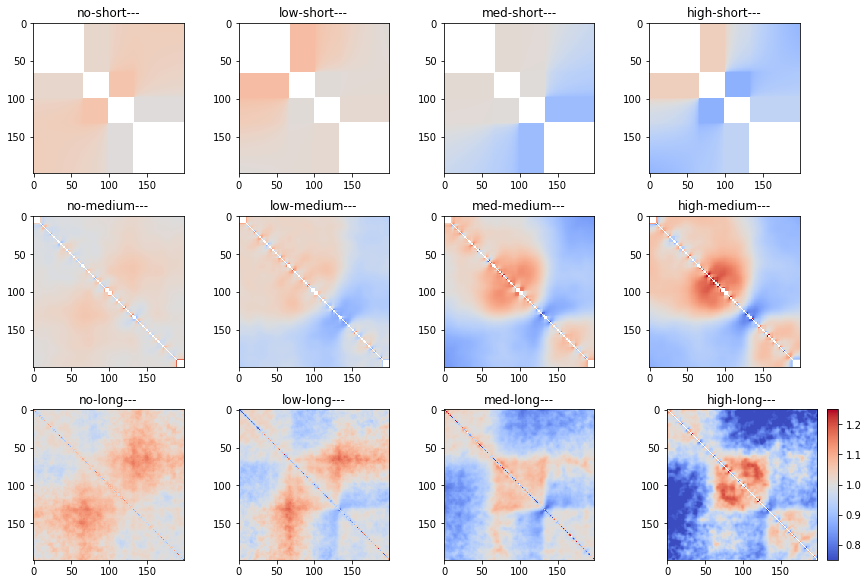

In [281]:
glens=("short","medium","long")
gexps=("no","low","med","high")


fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))
orient="--"

_yyyy = pup_dict["Ctrl500M-CT442-NT.hg19"].reset_index().set_index(["gexp","gsize","orientation"])

# divnorm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        pup_heatmap = _yyyy.loc[(gexp,glen,orient),"data"]
        img = ax.imshow(
            pup_heatmap,
#             norm = MidPointLogNorm(vmin=0.75,vmax=1.25,midpoint=1),
            norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
            cmap="coolwarm",
            interpolation="nearest",            
        )
        ax.set_title(f"{gexp}-{glen}-{orient}") 
plt.colorbar(img)

In [254]:
xxx = np.random.random(100).reshape((10,10))

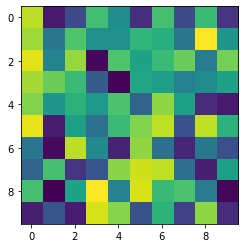

In [255]:
plt.imshow(xxx,interpolation="nearest")

In [256]:
from cooltools import numutils

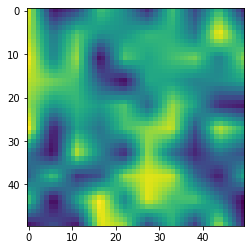

In [257]:
rrr = numutils.zoom_array(
    xxx,
    (50,50),
)
plt.imshow(rrr,interpolation="none")

In [134]:
from scipy import ndimage, misc

In [165]:
result = ndimage.zoom(xxx, 0.1)

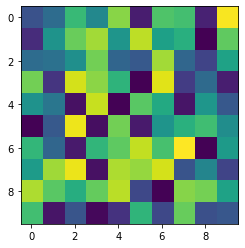

In [166]:
plt.imshow(result,interpolation="none")

In [ ]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
>>>
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, 3.0)
ax1.imshow(ascent, vmin=0, vmax=255)
ax2.imshow(result, vmin=0, vmax=255)
plt.show()

In [110]:
sites = all_genes[
    (all_genes["size"] > 70_000) & \
    (all_genes["size"] > 20)
][["chrom","start","end","strand"]]
cc = cp.CoordCreator(sites, resolution=binsize, basetype='bed', local=True, fraction_pad=1.)


pu = cp.PileUpper(
    clr,
    cc,
    control = True,
    rescale = True,
    rescale_size = 300,
)


# pup = pu.pileupsWithControl()

In [111]:
pup = pu.pileupsByStrandWithControl(nproc=3)

In [113]:
pup

,orientation,data,n
0,--,"[[1.0186257094787887, 1.0085807247139347, 0.95...",2152
1,++,"[[1.0490065639766117, 1.0262651402601197, 0.95...",2259


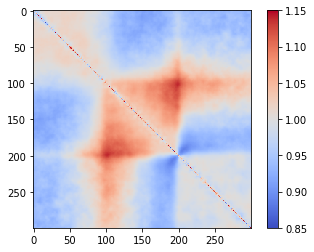

In [118]:
plt.imshow(pup["data"].values[0],interpolation="nearest",cmap="coolwarm",vmin=0.85,vmax=1.15)
plt.colorbar()

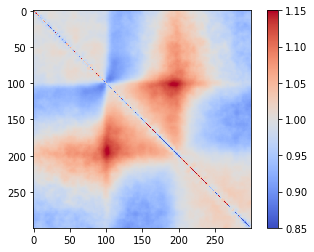

In [117]:
plt.imshow(pup["data"].values[1],interpolation="nearest",cmap="coolwarm",vmin=0.85,vmax=1.15)
plt.colorbar()

(<Figure size 525x450 with 4 Axes>,
 array([[<mpl_toolkits.axes_grid1.mpl_axes.Axes object at 0x7f6a48be6c10>,
       dtype=object),
 [<matplotlib.colorbar.Colorbar at 0x7f6a430e75e0>])

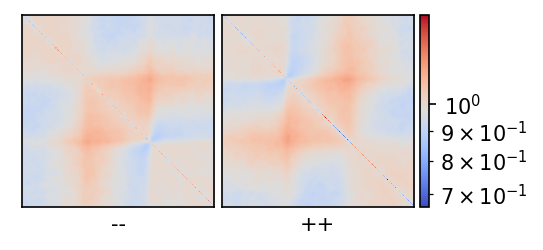

In [114]:
cp.make_heatmap_grid(pup, cols='orientation', col_order=['--', '++'], score=False, cmap='coolwarm', scale='log', sym=False)


(<Figure size 525x450 with 4 Axes>,
 array([[<mpl_toolkits.axes_grid1.mpl_axes.Axes object at 0x7f6a48ff7af0>,
       dtype=object),
 [<matplotlib.colorbar.Colorbar at 0x7f6a48c5e910>])

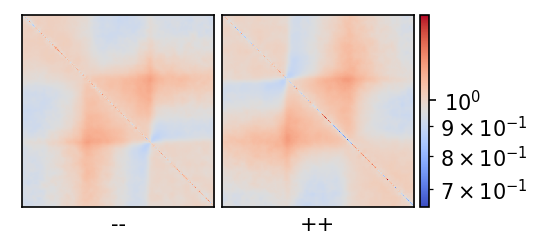

In [60]:
cp.make_heatmap_grid(pup, cols='orientation', col_order=['--', '++'], score=False, cmap='coolwarm', scale='log', sym=False)


In [42]:
 cp.CoordCreator
    resolution=
    basetype='bed'
    local=True
fraction_pad = 1

In [38]:
binsize = 10_000
binsize_human = f"{int(binsize/10_000)}kb"

all_genes[
    (all_genes["strand"] == "+") & \
    (all_genes["size"] > 70_000) & \
    (all_genes["size"] > 20)
][["chrom","start","end"]].to_csv("tmp.bed",index=False,header=None,sep="\t")


cname = ins_samples["CkoCT442_IAA_pool.hg19"]

! coolpup.py \
    {cname}::/resolutions/{binsize} \
    tmp.bed \
    --rescale \
    --local \
    --rescale_size 199 \
    --rescale_pad 1

Namespace(anchor=None, baselist='tmp.bed', basetype='auto', by_distance=False, by_strand=False, by_window=False, coolfile='CkoCT442-IAA-pool.mcool::/resolutions/10000', coverage_norm=False, excl_chrs='chrY,chrM', expected=None, ignore_diags=2, incl_chrs='all', local=True, logLevel='INFO', maxdist=None, maxshift=1000000, mindist=None, minshift=100000, n_proc=1, nshifts=10, ooe=True, outname='auto', pad=100, post_mortem=False, regions=None, rescale=True, rescale_pad=1.0, rescale_size=199, seed=None, subset=0, unbalanced=False, weight_name='weight')
chr1: 199
chr2: 209
chr3: 180
chr4: 135
chr5: 174
chr6: 135
chr7: 121
chr8: 109
chr9: 103
chr10: 104
chr11: 105
chr12: 117
chr13: 64
chr14: 80
chr15: 87
chr16: 57
chr17: 74
chr18: 53
chr19: 29
chr20: 53
chr21: 28
chr22: 43
Total number of piled up windows: 2259
/home/sergpolly/Desktop/src/coolpuppy/coolpuppy/coolpup.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-typ

In [39]:
xxx = fl.load("CkoCT442-IAA-pool-10.0K_over_tmp_10-shifts_local_rescaled.clpy")

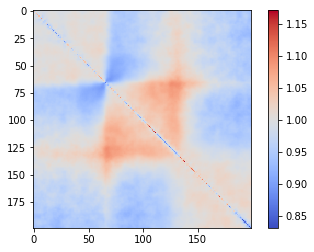

In [40]:
plt.imshow(xxx["data"]["data"].values[0],interpolation="nearest",cmap="coolwarm")
plt.colorbar()

In [17]:
import flammkuchen as fl

# foo_shape = 
fl.meta("CkoCT442-NT-pool-10.0K_over_tmp_10-shifts_local_rescaled.clpy", "/foo").shape
# # (10, 20)

# for i in range(foo_shape[0]):
#     a_tiny_slice = fl.load("test.h5", "/foo", sel=fl.aslice[i, :])
#     print(a_tiny_slice.shape)
#     # (20, )

Exception: Node foo not available!

In [16]:
!plotpup.py CkoCT442-NT-pool-10.0K_over_tmp_10-shifts_local_rescaled.clpy --output xxx.png

Traceback (most recent call last):
  File "/home/sergpolly/miniconda3/envs/devcool/bin/plotpup.py", line 33, in <module>
    sys.exit(load_entry_point('coolpuppy', 'console_scripts', 'plotpup.py')())
  File "/home/sergpolly/Desktop/src/coolpuppy/coolpuppy/__plotpuppy_main__.py", line 147, in main
    pups = [load_array_with_header(f)["data"] for f in args.pileup_files]
  File "/home/sergpolly/Desktop/src/coolpuppy/coolpuppy/__plotpuppy_main__.py", line 147, in <listcomp>
    pups = [load_array_with_header(f)["data"] for f in args.pileup_files]
  File "/home/sergpolly/Desktop/src/coolpuppy/coolpuppy/coolpup.py", line 104, in load_array_with_header
    read_data = f.read()
  File "/home/sergpolly/miniconda3/envs/devcool/lib/python3.8/codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


In [11]:
! coolpup.py --help

usage: coolpup.py [-h] [--basetype {bed,bedpe,auto}] [--regions REGIONS]
                  [--pad PAD] [--minshift MINSHIFT] [--maxshift MAXSHIFT]
                  [--nshifts NSHIFTS] [--expected EXPECTED] [--ooe OOE]
                  [--mindist MINDIST] [--maxdist MAXDIST]
                  [--ignore_diags IGNORE_DIAGS] [--excl_chrs EXCL_CHRS]
                  [--incl_chrs INCL_CHRS] [--subset SUBSET] [--anchor ANCHOR]
                  [--by_window] [--by_strand] [--by_distance] [--local]
                  [--unbalanced] [--coverage_norm] [--rescale]
                  [--rescale_pad RESCALE_PAD] [--rescale_size RESCALE_SIZE]
                  [--weight_name WEIGHT_NAME] [--n_proc N_PROC]
                  [--outname OUTNAME] [--seed SEED]
                  [-l {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [--post_mortem]
                  [-v]
                  coolfile baselist

positional arguments:
  coolfile              Cooler file with your Hi-C data
  baselist              A 3-colum

In [13]:
!ls -lah  CkoCT442-NT-pool*

-rw-rw-r-- 1 sergpolly sergpolly 1.4M Jun  1 12:06 CkoCT442-NT-pool-10.0K_over_tmp_10-shifts_local_rescaled.clpy
-rw-rw-r-- 1 sergpolly sergpolly 113M Apr 22 12:18 CkoCT442-NT-pool.2kb.cis.exp.tsv
-rw-r--r-- 1 sergpolly sergpolly 3.2G Apr 14 20:15 CkoCT442-NT-pool-500000000.mcool
-rw-rw-r-- 1 sergpolly sergpolly 4.4G Mar 24 14:44 CkoCT442-NT-pool.mcool
-rw-rw-r-- 1 sergpolly sergpolly  23M Apr  5 19:15 CkoCT442-NT-pool.mcool.10kb.exp.tsv


In [ ]:
binsize = 5_000
binsize_human = f"{int(binsize/1_000)}kb"

hg19_chromsizes = bioframe.fetch_chromsizes("hg19")

# iterate over samples to calculate insulation on:
for k,cname in ins_samples.items():
    target_bw_file = Path(f"{k}.{binsize_human}.{diamond_human}.bw")
    if target_bw_file.is_file():
        print("already exist !")
        print(target_bw_file)
        continue
    else:
        print("working on ...")
        print(k,cname)
        ######################################
        ! cooltools diamond-insulation \
            -o {k}.{binsize_human}.{diamond_human}.tsv \
            {cname}::/resolutions/{binsize} \
            {diamond}
        ###################################### 
        df = bioframe.read_table(
                f"{k}.{binsize_human}.{diamond_human}.tsv",
                header=0
        )
        ######################################
        bioframe.to_bigwig(
            df,
            hg19_chromsizes,
            f"{k}.{binsize_human}.{diamond_human}.bw",
            value_field = f"log2_insulation_score_{diamond}"
        )


```coolpup.py my_hic_data.cool my_domains.bed --rescale --local --rescale_size 199 --rescale_pad 1```

To perform this analysis, you simply need to call
coolpup.py my_hic_data.cool my_domains.bed --rescale --local
(with optional --expected my_hic_data_expected.tsv - see details below).
To specify the side of the final matrix as 99 bins add --rescale_size 99.
Another useful option here is --rescale_pad, which defines the fraction of the original regions to use when padding them;
the default value is 1, so each TAD is flanked on each side by a region of the same size.